In [10]:
import Functions as F
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import os
import pickle
import pandas as pd
from sklearn.utils import resample

pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

In [9]:
def get_pickles(): 
    x_train = pickle.load(open('../Pickles/2_x_train.p', 'rb'))
    x_test = pickle.load(open('../Pickles/2_x_test.p', 'rb'))
    y_train = pickle.load(open('../Pickles/2_y_train.p', 'rb'))
    y_test = pickle.load(open('../Pickles/2_y_test.p', 'rb'))
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = get_pickles()
print(x_train.shape, x_test.shape) 
print(y_train.shape, y_test.shape)

(2661, 5000) (887, 5000)
(2661,) (887,)


In [13]:
models = {'DT': DecisionTreeClassifier(),
          'Gaussian': GaussianNB(),
          'LDA': LinearDiscriminantAnalysis(),
          'LinearSVC': LinearSVC(max_iter = 1250),
          'SDGSVC': SGDClassifier(),  
          'ADA': AdaBoostClassifier(),
          'Bagging': BaggingClassifier(),
          'Ridge': RidgeClassifier(), 
          'RF': RandomForestClassifier()}

#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5)
    scores = cross_val_score(m, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = 2, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)


Evaluating STACKED: 100%|██████████| 10/10 [2:01:14<00:00, 727.44s/it] 


In [ ]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('../models/VanillaResults.p', 'wb'))

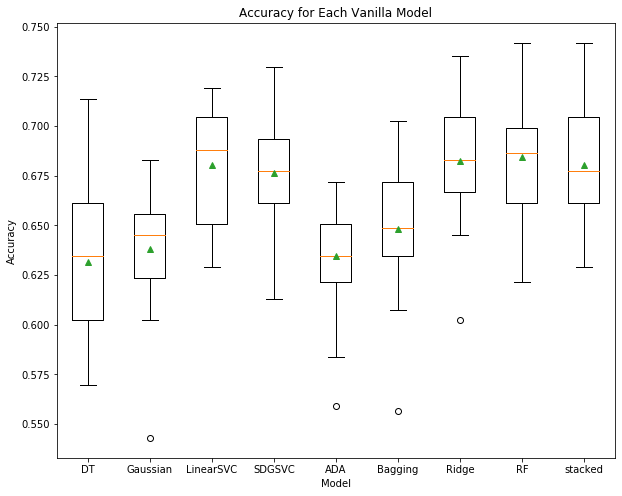

In [25]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('../figures/Binary_2_BaselineAccuracy.png')
plt.show()

In [20]:
print('Original Train Value Counts')
print(y_train.value_counts())
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Original Test Value Counts')
print(y_test.value_counts())
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


train_df = pd.DataFrame(x_train)
train_df['target'] = y_train.values 

neg_df = train_df[train_df.target == 0]
pos_df = train_df[train_df.target == 1]



resample_pos = resample(pos_df, n_samples = 500, random_state = 10, replace = False)
# resample_neut = resample(neut_df, n_samples = 500, random_state = 10, replace = False)

final_df= neg_df.append(resample_pos, ignore_index = True)
# final_df = final_df.append(resample_neut, ignore_index = True)
print('Final Resampled Value Counts')
print(final_df.target.value_counts())
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


x_train_new = final_df[[i for i in final_df.columns if i != 'target']]
y_train_new = final_df[['target']].values.ravel()

Original Train Value Counts
1.0    2233
0.0     428
Name: Emotion_New, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original Test Value Counts
1.0    745
0.0    142
Name: Emotion_New, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Final Resampled Value Counts
1.0    500
0.0    428
Name: target, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [21]:
models = {'DT': DecisionTreeClassifier(random_state= 10),
          'Gaussian': GaussianNB(),
          'LinearSVC': LinearSVC(max_iter = 1250),
          'SDGSVC': SGDClassifier(),  
          'ADA': AdaBoostClassifier(),
          'Bagging': BaggingClassifier(),
          'Ridge': RidgeClassifier(), 
          'RF': RandomForestClassifier(random_state= 10)}

#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5)
    scores = cross_val_score(m, x_train_new, y_train_new, scoring = 'accuracy', cv = cv, n_jobs = 2, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)


Evaluating STACKED: 100%|██████████| 9/9 [13:59<00:00, 93.26s/it] 


In [24]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('../models/Binary_2_VanillaResults.p', 'wb'))

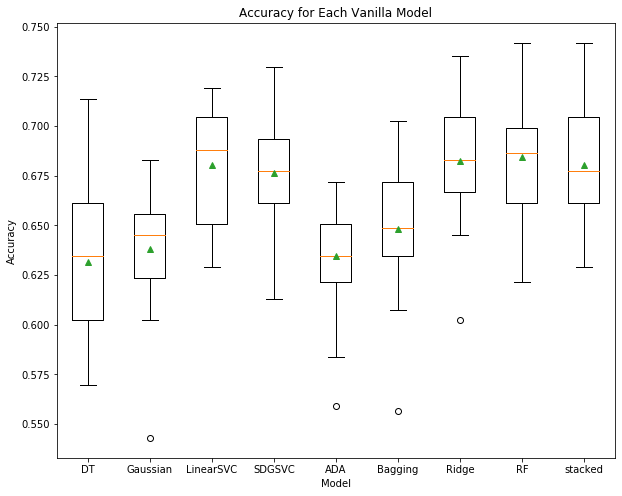

In [25]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('../figures/Binary_2_BaselineAccuracy.png')
plt.show()